# Setup Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!pip install kaggle


In [ ]:
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d fantineh/next-day-wildfire-spread

In [ ]:
!unzip /content/next-day-wildfire-spread.zip

In [ ]:
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import tensorflow_datasets as tfds
from keras.callbacks import ModelCheckpoint

In [ ]:
train_file_pattern = '/content/next_day_wildfire_spread_train*'
val_file_pattern = '/content/next_day_wildfire_spread_eval*'
test_file_pattern = '/content/next_day_wildfire_spread_test*'

In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

DATA_STATS = {'elevation': (0.0, 3141.0, 657.3003, 649.0147), 'pdsi': (-6.1298, 7.8760, -0.0053, 2.6823), 'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677), 'pr': (0.0, 44.5304, 1.7398051, 4.4828), 'sph': (0., 1., 0.0071658953, 0.0042835088), 'th': (0., 360.0, 190.3298, 72.5985), 'tmmn': (253.15, 298.9489, 281.08768, 8.9824), 'tmmx': (253.15, 315.0923, 295.17383, 9.8155), 'vs': (0.0, 10.0243, 3.8501, 1.4110), 'erc': (0.0, 106.2489, 37.3263, 20.8460), 'population': (0., 2534.0630, 25.5314, 154.7233), 'PrevFireMask': (-1., 1., 0., 1.), 'FireMask': (-1., 1., 0., 1.)} 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox


In [ ]:
def input_output_images(input_img:tf.Tensor, output_img:tf.Tensor, sample_size:int, num_in_channels:int, num_out_channels:int):
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(combined,[sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img
  #return combined
#input_output_images(input_img, output_img, sample_size, num_in_channels, 1)


In [ ]:

def random_crop_input_and_output_images(input_img:tf.Tensor, output_img:tf.Tensor, sample_size:int, num_in_channels:int, num_out_channels:int,) -> Tuple[tf.Tensor, tf.Tensor]:
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(input_img: tf.Tensor, output_img: tf.Tensor, sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

In [ ]:

def _get_base_key(key: Text) -> Text:
  match = re.match(r'[a-zA-Z]+', key)
  if match:
    return match.group(1)
  raise ValueError(
      f'The provided key does not match the expected pattern: {key}')


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(example_proto: tf.train.Example, data_size: int, sample_size: int, num_in_channels: int, clip_and_normalize: bool, clip_and_rescale: bool, random_crop: bool, center_crop: bool,) -> Tuple[tf.Tensor, tf.Tensor]:
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [_clip_and_normalize(features.get(key), key) for key in input_features]
  elif clip_and_rescale:
    inputs_list = [_clip_and_rescale(features.get(key), key) for key in input_features]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3''but dimensions of outputs_stacked'f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  # insert empty dimension to make it work with ConvLSTM
  # input_img = tf.expand_dims(input_img, axis=0)
  # output_img = tf.expand_dims(output_img, axis=0)

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int, batch_size: int, num_in_channels: int, compression_type: Text, clip_and_normalize: bool, clip_and_rescale: bool, random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(lambda x: _parse_fn(x, data_size, sample_size, num_in_channels, clip_and_normalize, clip_and_rescale, random_crop, center_crop),num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
train_dataset = get_dataset(
  train_file_pattern,
  data_size=64,
  sample_size=32,
  batch_size=100,
  num_in_channels=12,
  compression_type=None,
  clip_and_normalize=False,
  clip_and_rescale=False,
  random_crop=True,
  center_crop=False
)

val_dataset = get_dataset(
    val_file_pattern,
    data_size=64,
    sample_size=32,
    batch_size=1900,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize=False,
    clip_and_rescale=False,
    random_crop=True,
    center_crop=False
)

test_dataset = get_dataset(
    test_file_pattern,
    data_size=64,
    sample_size=32,
    batch_size=100,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize=False,
    clip_and_rescale=False,
    random_crop=True,
    center_crop=False
)

# Train

In [ ]:
from timeit import default_timer as timer
class TimingCallback(keras.callbacks.Callback):
  def __init__(self, logs={}):
    self.logs=[]
  def on_epoch_begin(self, epoch, logs={}):
    self.starttime = timer()
  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(timer()-self.starttime)
tcb = TimingCallback()

In [ ]:
# Define some callbacks to improve training.
# checkpoint = ModelCheckpoint("model.hdf5", monitor = 'val_auc', verbose = 1, save_best_only = False, period = 1)

def algo_train():
  early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

  # Define modifiable training hyperparameters.
  epochs = 20
  batch_size = 100

  # Fit the model to the training data.
  history = model.fit(
      features_np,
      firemask_np,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(features_val_np,firemask_val_np), 
      callbacks=[early_stopping, reduce_lr, tcb] # , checkpoint]
  )
  return history

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(1, 32, 32, 12))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=[tf.keras.metrics.AUC()]
)


In [ ]:
def clean_data(data):
  # handles rows with unknown/missing data
  rows_affected = set()
  for sample in range(len(data)):
    for i in range(32):
      for j in range(32):
        if data[sample,0,i,j,11] == -1:
          # make unknowns into not fires
          data[sample,0,i,j,11] = 0
          rows_affected.add(sample)
  return len(rows_affected)

In [ ]:
scores_auc = [] 
scores_loss = []

def sum_scores(history, sum_auc, sum_loss):
  scores = history.history
  result = scores.items()
  data = list(result)
  data_np = np.array(data)
  for x in range(len(data_np[0][1])):
    sum_auc = sum_auc + data_np[1][1][x]
    sum_loss = sum_loss + data_np[0][1][x]
  scores_auc.append(sum_auc/len(data_np[0][1]))
  scores_loss.append(sum_loss/len(data_np[0][1]))

In [ ]:
# reshape validation dataset
features_val, firemask_val = next(iter(val_dataset))
features_val_np = features_val.numpy()
firemask_val_np = firemask_val.numpy()
features_val_np = np.expand_dims(features_val_np, axis = 1)
print(clean_data(features_val_np))
firemask_val_np = np.expand_dims(firemask_val_np, axis = 1)

299


In [ ]:
global sum_auc, sum_loss
sum_auc = 0
sum_loss = 0
train_iter = iter(train_dataset)
total_time_to_train = timer()
for i in range(150):
  # features, firemask = next(iter(train_dataset))
  features, firemask = next(train_iter)
  features_np = features.numpy()
  firemask_np = firemask.numpy()
  features_np = np.expand_dims(features_np, axis = 1)
  print(clean_data(features_np))
  print(features_np.shape)

  
  firemask_np = np.expand_dims(firemask_np, axis = 1)
  # features_val, firemask_val = next(iter(val_dataset))
  history = algo_train()
  #model.save('drive.google.com/drive/folders/1jcYiH6yeu9H2TRSQXC5SdHJX2B5pMFoS?usp=sharing')
  print("ITERATION: ", i+1)
  sum_scores(history, sum_auc, sum_loss)

total_time_to_train = timer() - total_time_to_train()

In [ ]:
model.save("alimodel")

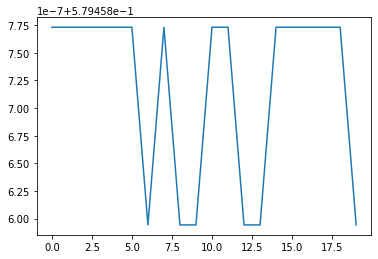

In [ ]:
plt.plot(history.history["auc_3"])


In [ ]:
history.history

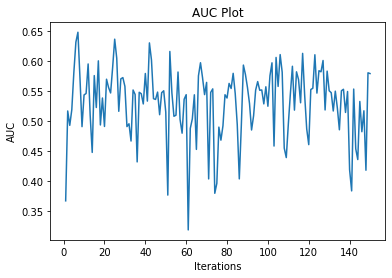

In [ ]:
iteration_arr = []

for i in range(150):
  iteration_arr.append(i+1)

plt.plot(iteration_arr, scores_auc)

plt.xlabel("Iterations")
plt.ylabel("AUC")
plt.title("AUC Plot")

plt.show()


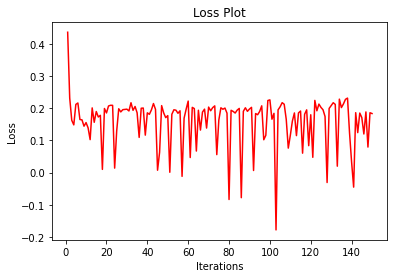

In [ ]:
plt.plot(iteration_arr, scores_loss, 'r')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.show()

In [ ]:
print(f"Average time per epoch: {sum(tcb.logs)/len(tcb.logs)} seconds")
# print(f"Total Time taken: {sum(tcb.logs)}")
print(f"Total time taken to train: {total_time_to_train} seconds")

In [ ]:
model.summary()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
#model = Sequential()
#model.add(Dense(2, input_dim=1, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir = 'TB', expand_nested = True)


# Vizualization code


In [ ]:
def print_arr(arr):
  for i in range(32):
    print(i,end=' :\t')
    for j in range(32):
      print(arr[i,j],end=',\t')
    print()

In [ ]:
# import matplotlib as mpl
# # cmap = mpl.colors.ListedColormap(["black", "gray", "red"])


# # define color map 
# color_map = {1: np.array([255, 0, 0]), # red
#              0: np.array([220,220,220]), # gray
#              -1: np.array([0, 0, 0])} # black

# def recolor(data):
#   out = np.zeros(shape=(32,32,3),dtype=int)
#   for i in range(0, data.shape[0]):
#     for j in range(0, data.shape[1]):
#         out[i][j] = color_map[data[i][j]]
#   return out

In [ ]:
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

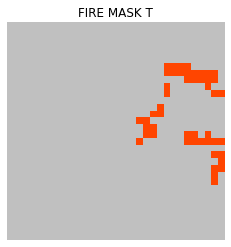

In [ ]:
SAMPLE = 1  # row
FIREMASK_IDX = 11  # the index of the feature with the firemask at t
x_pred = np.zeros(shape=(32,32))
for i in range(32):
  for j in range(32):
    x_pred[i,j] = features_val_np[SAMPLE][0][i,j][FIREMASK_IDX]
# plt.imshow(recolor(x_pred))
x_pred = features_val_np[SAMPLE, 0, :, :, FIREMASK_IDX]
plt.imshow(x_pred, cmap=CMAP, norm=NORM)
# print(recolor(x_pred).ravel()[0:1024].reshape((32,32)))
plt.title("FIRE MASK T")
plt.axis("off")
plt.show()

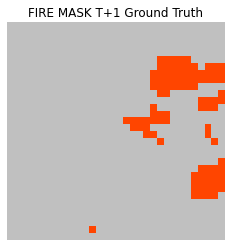

In [ ]:
y_true = firemask_val_np[SAMPLE].reshape([32,32])
# plt.imshow(recolor(y_true))
plt.imshow(y_true, cmap=CMAP, norm=NORM)
plt.title("FIRE MASK T+1 Ground Truth")
plt.axis("off")
plt.show()

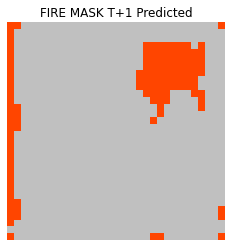

In [ ]:
x = np.expand_dims(features_val_np[SAMPLE],axis=0)
y_pred = model.predict(x)
y_pred_reshaped = y_pred.ravel().reshape((32,32))

CMAP = colors.ListedColormap(['silver', 'orangered'])
BOUNDS = [0.0, 0.25, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

plt.imshow(y_pred_reshaped,cmap=CMAP, norm=NORM)
# plt.imshow(y_pred_reshaped)
# plt.colorbar()
plt.title("FIRE MASK T+1 Predicted")
plt.axis("off")
plt.show()

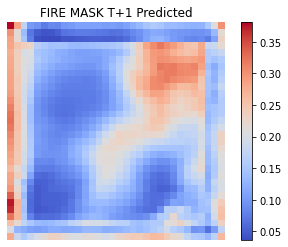

In [ ]:
x = np.expand_dims(features_val_np[SAMPLE],axis=0)
y_pred = model.predict(x)
y_pred_reshaped = y_pred.ravel().reshape((32,32))

plt.imshow(y_pred_reshaped, cmap="coolwarm")
# plt.imshow(y_pred_reshaped)
plt.colorbar()
plt.title("FIRE MASK T+1 Predicted")
plt.axis("off")
plt.show()

Text(0.5, 1.0, 'Predicted')

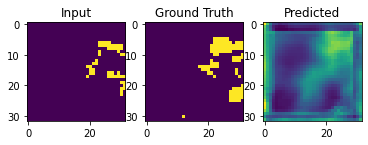

In [ ]:
fig, axs = plt.subplots(1,3)
# fig.suptitle('Firemasks')
axs[0].imshow(x_pred)
axs[0].set_title("Input")
axs[1].imshow(y_true)
axs[1].set_title("Ground Truth")
axs[2].imshow(y_pred_reshaped)
axs[2].set_title("Predicted")
# fig.axis("off")